# Progetto DSIM - Face recognition

---



Autori: Ginevra Mariani | Lorenzo Mora | Confalonieri Riccardo <br>
E-mail: g.mariani34@campus.unimib.it | l.mora4@campus.unimib.it | r.confalonieri5@campus.unimib.it

L'obiettivo di questo notebook è creare un classificatore che riconosca i volti dei $3$ componenti del gruppo. A tale scopo verranno provati approcci di fine tuning con pesi addestrati sul task imagenet e una rete preaddestrata su un task di riconoscimento dei volti. <br>
Per quanto concerne le immagini date in input ai modelli si utilizzeranno dei crop, preventivamente ottenuti, contenenti il solo volto della persona.

## Import packages

In [ ]:
# scarico i dati necessari per il face detector dlib
!wget http://dlib.net/files/mmod_human_face_detector.dat.bz2 
# estraggo lo zip
!bzip2 -dk mmod_human_face_detector.dat.bz2

import os
# rimuovo lo zip che non è più necessario
os.remove('mmod_human_face_detector.dat.bz2')

--2022-02-05 11:06:11--  http://dlib.net/files/mmod_human_face_detector.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 694709 (678K)
Saving to: ‘mmod_human_face_detector.dat.bz2’

mmod_human_face_det 100%[===================>] 678.43K  3.20MB/s    in 0.2s    

2022-02-05 11:06:12 (3.20 MB/s) - ‘mmod_human_face_detector.dat.bz2’ saved [694709/694709]



In [ ]:
# caricamento e salvataggio su drive
from google.colab import drive

# per estrazione file zip
import zipfile
import shutil

# per gestione label
import numpy as np

# per plot immagini
import matplotlib.pyplot as plt
import random

# per face detector
import cv2 as cv
import dlib # dlib face detector

# per valutare i risultati
from sklearn.metrics import confusion_matrix
import seaborn as sns # plot confusion matrix
from sklearn.metrics import classification_report
import time # per tempo predizione

# --- CNN ---
from keras.preprocessing.image import image_dataset_from_directory # per import del dataset
from tensorflow import keras # per creazione dei modelli 
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # modello mobilenet_v2
from tensorflow.keras.applications.vgg16 import VGG16 # modello vgg16
# Funzioni di ottimizzazione
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model # per costruire modelli da input/output
from keras.callbacks import EarlyStopping # early_stopping regularization
# per semplificare la definizione del modello VGGFace
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import ZeroPadding2D,Convolution2D,MaxPooling2D

In [ ]:
# caricamento drive
drive.mount('/content/drive', force_remount=True)

# path principale delle cartella
drive_path = '/content/drive/MyDrive/Confalonieri_Mariani_Mora_DSIM/'

Mounted at /content/drive


## Image cropping
Per poter addestrare i modelli è necessario ritagliare le immagini a disposizione estraendo il riquadro contenente il solo volto della persona. Per farlo si sono utilizzati dei face detector ad hoc, e sono state considerate due implementazioni:


*   OpenCV: face detector più veloce, ma non riesce a individuare i volti in molte situazioni
*   dlib: face detector basato su una CNN, molto più efficiente ma richiede qualche istante in più per ogni immagine.

Si sono testati entrambi i face detector, i cui metodi di estrazione sono presenti nelle due sezioni successive per chiarezza, ma alla fine i volti sono stati estratti usando dlib che ha permesso di croppare con successo tutte le immagini a disposizione! <br>

**NOTA:** Una volta ottenuti i crop si è proceduto a mano a creare i relativi .zip, e nel caso delle immagini di training/validation si è proceduto con una separazione manuale in due sottocartelle. Tuttavia si poteva anche procedere con una suddivisione automatica via codice!

**NOTA2:** Dato che gli .zip sono salvati su drive questo codice ***non va eseguito***, è stato lasciato solo per completezza!



### Face detector: OpenCV
La prima opzione considerata per effettuare i crop delle immagini è stata quella di utilizzare il face detector fornito da OpenCV.

In [ ]:
# carico il modello di face detection pre-addestrato
face_detector = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [ ]:
def check_folder(folder_name):
  """
  Verifica se esiste una cartella con il nome specificato nel path locale,
  se non esiste la crea.
  
  :param str folder_name: Nome della cartella
  """
  
  # se non esiste la creo
  if not os.path.exists(folder_name):
    print("----- Creating folder: ./" + str(folder_name))
    os.mkdir(folder_name)

def save_pic_cropped(original_path, dest_path):
  """
  Funzione che scorre tutte le immagini presenti in un dato path e, applicando
  un face detector, estrae il crop relativo al volto salvandolo nel path di destinazione
  specificato. Se l'immagine non contiene volti verrà saltata.
  
  :param str original_path: Percorso della cartella contenente le immagini da croppare
  :param str dest_path: Percorso della cartella in cui salvare i crop delle immagini
  """


  # se non esiste creo la cartella di destinazione
  check_folder(dest_path)

  # scorro su tutte le cartelle presenti
  for person_path in os.listdir(original_path):
    # definisco il nuovo percorso unendo le due stringhe
    fold_path = os.path.join(original_path, person_path)

    # se è una cartella allora itero su tutte le immagini
    # altrimenti è un file .zip che non mi interessa!
    if os.path.isdir(fold_path):
      # arrivato qui sono sicuro di essere in una cartella che contiene immagini
      # itero su tutte queste immagini, applico il face detector e salvo il crop della faccia
      # nel nuovo percorso
      for img_path in os.listdir(fold_path):
        img = cv.imread(os.path.join(fold_path, img_path))

        # converto l'immagine in bianco e nero
        img_bw = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        
        # applico il face detector sull'immagine in b/n
        faces = face_detector.detectMultiScale(img_bw, 1.1, 8)

        # stampe di controllo per i casi anomali
        if len(faces) == 0:
          print('Nessun crop valido per immagine:', img_path)
        if len(faces) > 2:
          print('Più crop validi per immagine:', img_path)

        count = 0
        # per ogni volto trovato croppo l'immagine e la salvo nella nuova directory
        # l'ipotesi ideale è che ci sia un solo volto ma ci sono casi in cui ce ne sono 0
        # o più di 1
        for (x,y,w,h) in faces:
          # estraggo il crop
          crop = img[y:y+h, x:x+w]
          # modifico il nuovo nome dell'immagine aggiungendo un contatore
          # cosi salvo anche eventuali immagini duplicate con lo stesso nome
          temp_path = os.path.splitext(img_path)[0] + '_' + str(count) + '.jpg'

          # verifico che esista la sottocartella col nome della persona per il salvataggio
          check_folder(os.path.join(dest_path, person_path))
          
          # salvo la nuova immagine
          cv.imwrite(os.path.join(dest_path, person_path, temp_path), crop)

          # aumento il contatore per gestire eventuali detection multiple
          count = count+1

In [ ]:
# croppo tutte le immagini di training/validation in una cartella
save_pic_cropped(drive_path + 'Data/immagini/Train_Validation', drive_path + 'Data/immagini/crop')

# croppo tutte le immagini di test in una cartella
#save_pic_cropped(drive_path + 'Data/immagini/Train_Validation', drive_path + 'Data/immagini/crop_test')

----- Creating folder: .//content/drive/MyDrive/DSIM_progetto/Data/immagini/crop
----- Creating folder: .//content/drive/MyDrive/DSIM_progetto/Data/immagini/crop/Lorenzo
Nessun crop valido per immagine: lorenzo_01-24-2022_120918.jpg
Nessun crop valido per immagine: lorenzo_01-24-2022_120926.jpg
Nessun crop valido per immagine: lorenzo_01-24-2022_120946.jpg
Nessun crop valido per immagine: lorenzo_01-24-2022_120950.jpg
Nessun crop valido per immagine: lorenzo_01-24-2022_121022.jpg
Nessun crop valido per immagine: lorenzo_01-24-2022_121026.jpg
Nessun crop valido per immagine: lorenzo_01-24-2022_121051.jpg
Nessun crop valido per immagine: lorenzo_01-24-2022_121055.jpg
Nessun crop valido per immagine: lorenzo_01-24-2022_121103.jpg
Nessun crop valido per immagine: lorenzo_01-24-2022_121111.jpg
Nessun crop valido per immagine: lorenzo_01-24-2022_121115.jpg
Nessun crop valido per immagine: lorenzo_01-24-2022_121123.jpg
Nessun crop valido per immagine: lorenzo_01-24-2022_121127.jpg
Nessun crop

Come si può notare già per le immagini di training e validation molte non sono croppate con successo! Quindi si è passatti al face detector di dlib.

### Face detector: dlib
Per l'implementazione del codice ci si è basati alla documentazione della libreria presente al seguente [link](http://dlib.net/cnn_face_detector.py.html). <br>

L'aspetto negativo di questo face detector è che richiede una GPU, in Colab non vi sono tuttavia problemi con la sua esecuzione.

In [ ]:
def check_folder(folder_name):
  """
  Verifica se esiste una cartella con il nome specificato nel path locale,
  se non esiste la crea.
  
  :param str folder_name: Nome della cartella
  """
  
  # se non esiste la creo
  if not os.path.exists(folder_name):
    print("----- Creating folder: ./" + str(folder_name))
    os.mkdir(folder_name)

def save_pic_cropped(original_path, dest_path):
  """
  Funzione che scorre tutte le immagini presenti in un dato path e, applicando
  un face detector, estrae il crop relativo al volto salvandolo nel path di destinazione
  specificato. Se l'immagine non contiene volti verrà saltata.
  
  :param str original_path: Percorso della cartella contenente le immagini da croppare
  :param str dest_path: Percorso della cartella in cui salvare i crop delle immagini
  """

  # se non esiste creo la cartella di destinazione
  check_folder(dest_path)

  # istanzio il face detector dlib
  # richiede la presenza di GPU --> se non c'è da errore
  face_detector2 = dlib.cnn_face_detection_model_v1("/content/mmod_human_face_detector.dat")

  # scorro su tutte le cartelle presenti
  for person_path in os.listdir(original_path):
    # definisco il nuovo percorso unendo le due stringhe
    fold_path = os.path.join(original_path, person_path)

    # se è una cartella allora itero su tutte le immagini
    # altrimenti è un file .zip che non mi interessa!
    if os.path.isdir(fold_path):
      # arrivato qui sono sicuro di essere in una cartella che contiene immagini
      # itero su tutte queste immagini, applico il face detector e salvo il crop della faccia
      # nel nuovo percorso
      for img_path in os.listdir(fold_path):
        img = cv.imread(os.path.join(fold_path, img_path))


        # dlib si aspetta un imamgine a colori RGB, quindi converto i colori
        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)


        # applico il face detector dlib.
        # Il secondo parametro (2) indica che l'immagine verrà ingrandita 2 volte. Cosi
        # possiamo individuare facce anche più lontare (es. ci allontaniamo dalla telecamera)
        faces = face_detector2(img_rgb, 2)

        # stampe di controllo per i casi anomali
        if len(faces) == 0:
          print('Nessun crop valido per immagine:', img_path)
        if len(faces) > 2:
          print('Più crop validi per immagine:', img_path)


        count = 0
        # per ogni volto trovato croppo l'immagine e la salvo nella nuova directory
        # l'ipotesi ideale è che ci sia un solo volto ma ci sono casi in cui ce ne sono 0
        # o più di 1
        for i, d in enumerate(faces):
          left=d.rect.left() #x1
          top=d.rect.top() #y1
          right=d.rect.right() #x2
          bottom=d.rect.bottom() #y2

          # gestisco possibili errori nei valori
          left = max(0, left)
          top = max(0, top)

          # calcolo larghezza e altezza dell'immagine
          width=right-left
          height=bottom-top

          # confidence della detection
          confidence = d.confidence
          
          # print di alert se vengono individuati piu di due volti
          if (i >= 1):
            print('Immagine: ', img_path, 'confidence: ', confidence)
          
          # estraggo il crop
          crop = img[top:top+height, left:left+width]
          # modifico il nuovo nome dell'immagine aggiungendo un contatore
          # cosi salvo anche eventuali immagini duplicate con lo stesso nome
          temp_path = os.path.splitext(img_path)[0] + '_' + str(i) + '.jpg'

          # verifico che esista la sottocartella col nome della persona per il salvataggio
          check_folder(os.path.join(dest_path, person_path))
          
          # salvo la nuova immagine
          cv.imwrite(os.path.join(dest_path, person_path, temp_path), crop)

In [ ]:
# estraggo tutte le immagini di training e validation
save_pic_cropped(drive_path + 'Data/immagini/Train_Validation', drive_path + 'Data/immagini/temp') 

# una volta ottenuta la cartella A MANO si è suddivisa in training e validation
# estrapolando 20 immagini per utente come validation

----- Creating folder: /content/drive/MyDrive/DSIM_progetto/Data/immagini/temp
----- Creating folder: /content/drive/MyDrive/DSIM_progetto/Data/immagini/temp/Lorenzo
----- Creating folder: /content/drive/MyDrive/DSIM_progetto/Data/immagini/temp/Ginevra
----- Creating folder: /content/drive/MyDrive/DSIM_progetto/Data/immagini/temp/Riccardo


In [ ]:
# estraggo tutte le immagini di test
save_pic_cropped(drive_path + 'Data/immagini/Test', drive_path + 'Data/immagini/temp2') 

----- Creating folder: /content/drive/MyDrive/DSIM_progetto/Data/immagini/temp2
----- Creating folder: /content/drive/MyDrive/DSIM_progetto/Data/immagini/temp2/Ginevra
----- Creating folder: /content/drive/MyDrive/DSIM_progetto/Data/immagini/temp2/Lorenzo
----- Creating folder: /content/drive/MyDrive/DSIM_progetto/Data/immagini/temp2/Riccardo


Come si può notare dagli output l'esecuzione non ha dato errori, e per tutte le immagini è stato trovato un crop valido.

## Data Loader
Per velocizzare il caricamento le immagini necessarie sono già state preventivamente <i>salvate in formato .zip e suddivise in sottocartelle</i>, ognuna contenente una specifica classe (i.e. persona). In questo modo è possibile utilizzare i metodi di import di keras che velocizzano ed ottimizzano il caricamento. Inoltre le immagini sono state divise preventivamente in training, validation e test set. Infine avendo creato manualmente le immagini si è certi che le classi siano bilanciate, questo supponendo che nel caso reale tutti e $3$ i componenti siano presenti nell'immagine altrimenti avrebbe più senso creare un test set sbilanciato a favore della persona maggiormente presente per verificare la bontà del modello.

In [ ]:
def load_zip(file_path, filename, delete_zip = True):
  """
  Funzione che copia in locale i file .zip e li estrai. Il file originale, se
  richiesto, viene eliminato.
  
  :param str file_path: Percorso per lo zip
  :param str filename: Nome dello zip
  :param boolean delete_zip: Indica se eliminare il file .zip scaricato. Default True
  """

  # Scarico sulla macchina locale lo zip
  shutil.copyfile(file_path, filename)
  # estraggo lo zip
  zip = zipfile.ZipFile(filename)
  zip.extractall()
  zip.close()
  # se richiesto cancello lo zip dalla root
  if delete_zip:
    os.remove(filename)


# funzione che importa le immagini di training, validation e test per il modello
def import_train_val_test(img_size = (224,224), batch_size = 16,
                          train_dir = './train', val_dir = './validation',
                          test_dir = './test'):
  
  """
  Importa le immagini di training, validation e test per il modello. 
  
  :param int() img_size: Dimensione delle immagini.
  :param str batch_size: Dimensione dei batch per i set
  :param str train_dir: Percorso della cartella contenente le immagini di training
  :param str val_dir: Percorso della cartella contenente le immagini di validation
  :param str test_dir: Percorso della cartella contenente le immagini di test

  :return: i tre dataset caricati
  :rtype: keras BatchDataset
  """
  
  print('------- Loading TRAIN SET -------')
  # carico tutto il training set in batch
  train_set = image_dataset_from_directory(
      # directory
      train_dir, 
      # estraggo in automatico le label
      labels = "inferred", label_mode = "categorical", 
      # se ci sono immagini non rgb vengono riconvertite in automatico
      color_mode = "rgb",
      # Evito che le immagini siano tutte in ordine consequenziale
      shuffle = True, 
      # Forzo la dimensione delle immagini a quella richiesta (necessario per fine-tuning)
      image_size = img_size, 
      # definisco la dimensione del batch
      batch_size = batch_size, 
      seed = 830404
  )

  print('\n\n------- Loading VALIDATION SET -------')
  # carico tutto il validation set in batch
  val_set = keras.preprocessing.image_dataset_from_directory(
      # directory
      val_dir, 
      # estraggo in automatico le label
      labels = "inferred", label_mode = "categorical", 
      # se ci sono immagini non rgb vengono riconvertite in automatico
      color_mode = "rgb",
      # Evito che le immagini siano tutte in ordine consequenziale
      shuffle = True, 
      # Forzo la dimensione delle immagini a quella richiesta (necessario per fine-tuning)
      image_size = img_size, 
      # definisco la dimensione del batch
      batch_size = batch_size, 
      seed = 830404
  )

  print('\n\n------- Loading TEST SET -------')
  # carico tutto il test set in batch
  test_set = keras.preprocessing.image_dataset_from_directory(
      # directory
      test_dir, 
      # estraggo in automatico le label
      labels = "inferred", label_mode = "categorical", 
      # se ci sono immagini non rgb vengono riconvertite in automatico
      color_mode = "rgb",
      shuffle = True,
      # Forzo la dimensione delle immagini a quella richiesta (necessario per fine-tuning)
      image_size = img_size,
      # definisco la dimensione del batch
      batch_size = batch_size,  
      seed = 830404
  )

  return train_set, val_set, test_set

In [ ]:
# scarico lo zip di training
load_zip(drive_path + 'Data/immagini/train.zip', 'train.zip')
# scarico lo zip di validation
load_zip(drive_path + 'Data/immagini/validation.zip', 'validation.zip')
# scarico lo zip di test
load_zip(drive_path + 'Data/immagini/test.zip', 'test.zip')

# importo il training, validation e test set
train_set, validation_set, test_set = import_train_val_test()

------- Loading TRAIN SET -------
Found 240 files belonging to 3 classes.


------- Loading VALIDATION SET -------
Found 60 files belonging to 3 classes.


------- Loading TEST SET -------
Found 51 files belonging to 3 classes.


In [ ]:
# Visualizzo alcune informazioni di base sulle immagini
print('Tipo delle immagini:', type(train_set))
# print('Numero di esempi di training:', train_set.samples)
print("Dimensione dell'immagine: " + str(train_set.element_spec[0].shape))
print("Tipo dei valori dell'immagine: ", train_set.element_spec[0].dtype)

Tipo delle immagini: <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Dimensione dell'immagine: (None, 224, 224, 3)
Tipo dei valori dell'immagine:  <dtype: 'float32'>


Il dataset caricato è di tipo proprietario di keras, inoltre possiamo notare che i valori presenti nell'immagine sono di tipo float e che le immagini sono state ridimensionate alla shape richiesta durante l'import.

### Visual inspection 
Proviamo a visualizzare qualche immagine per capirne le caratteristiche.

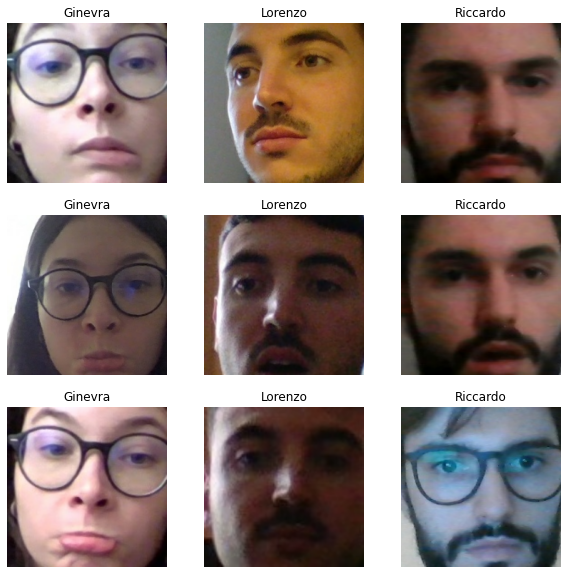

In [ ]:
# salvo tutti i nomi delle classi
class_names = train_set.class_names

# lista con indici delle immagini già visualizzate
lst_plotted_img = []

plt.figure(figsize=(10, 10))

# itero sul primo batch di immagini
for images, labels in train_set.take(1):
  i = 0

  while i < 9:
    # prendo un immagine random dal batch
    idx = random.randint(0,len(images)-1)
    # ottengo il numero della classe di riferimento per l'immagine
    class_number = np.argmax(labels[idx], axis=None, out=None)
    # se non ho già visualizzato l'immagine procedo
    if (idx not in lst_plotted_img) and (class_number == i%3):
      # aggiungo un nuovo subplot
      ax = plt.subplot(3, 3, i + 1)
      # visualizzo l'immagine
      plt.imshow(images[idx].numpy().astype("uint8"))
      # visualizzo come titolo il nome della classe
      plt.title(class_names[np.argmax(labels[idx], axis=None, out=None)])
      # tolgo la visualizzazione degli assi
      plt.axis("off")
      
      # aumento il contatore delle img visualizzate
      i = i+1
      # aggiorno la lista con gli indici già visualizzati
      lst_plotted_img.append(idx)

È possibile notare come nelle immagini contengono solo il soggetto da classificare, tuttavia ci sono variazioni di luce ed espressione tra le diverse immagini. In alcuni casi sono presenti anche le mani dei soggetti.

## Funzioni utili
Si definiscono alcune funzioni utili, comuni a tutti i modelli che verranno implementati. In questo modo è possibile visualizzare l'andamento del training con il confronto di loss e accuracy sul training e validation set ed anche effettuare le predizioni su un test set visualizzando i risultati in maniera grafica.

In [ ]:
def resume_model_history(history, early_stop = None, plot_size = (20,6)):
  """
  Visualizza a video alcune informazioni testuali di base sul training del modello 
  e due grafici per analizzare l'andamento della loss e dell'accuracy durante il training
  
  :param keras.callbacks.History history: Storia del modello, contiene i valori 
                                          di loss e accuracy per training e validation set
  :param keras.callbacks.EarlyStopping early_stop: Early stopping utilizzato per il modello,
                                                   None se non utilizzato. Default None
  :param int() plot_size: Dimensione del grafico. Default (20,6)
  """

  # estraggo il numero di epoche nel caso in cui l'early stopping è stato utilizzato
  if early_stop is not None:
    # verifico se l'early stop è entrato in funzione, se si prendo l'epoca in cui
    # si è fermato il training, altrimenti l'epoca migliore (corrisponderà al tot. max delle epoche)
    tot_epoch = early_stop.stopped_epoch+1 if (early_stop.stopped_epoch != 0) else early_stop.best_epoch + 1
    best_epoch = early_stop.best_epoch + 1
  # senza early_stopping l'ultima epoca e la migliore coincidono
  else:
    tot_epoch = len(history.epoch)
    best_epoch = tot_epoch

  # visualizzo i risultati in forma testuale
  print("Numero di epoche totali:", tot_epoch)
  print("Epoca migliore (weights restored):", best_epoch)
  print("Accuracy training set all'epoca " + str(best_epoch) + ': ' 
        + str(history.history['accuracy'][best_epoch -1]))
  print("Accuracy validation set all'epoca " + str(best_epoch) + ': '
        + str(history.history['val_accuracy'][best_epoch -1]))
  print("Loss training set all'epoca " + str(best_epoch) + ': '
        + str(history.history['loss'][best_epoch -1]))
  print("Loss validation set all'epoca " + str(best_epoch) + ': ' 
        + str(history.history['val_loss'][best_epoch -1]))
  
  print('\n\n')

  # visualizzo i grafici di loss e accuracy per training e validation
  fig = plt.figure(figsize = plot_size)

  plt.subplot(1, 2, 1)
  plt.xlabel('Epochs'); plt.ylabel('Loss');  plt.title('Model loss')
  # punti asse x
  plt.xticks(np.arange(len(history.epoch)), np.arange(1, len(history.epoch)+1))
  # visualizzo tutti i punti fino all'early stopping
  plt.plot(range(0,best_epoch,1), 
           history.history['loss'][:best_epoch], '.-', color="C0") # loss train
  plt.plot(range(0,best_epoch,1), 
           history.history['val_loss'][:best_epoch], '.-', color="C1") # loss val
  # visualizzo tutti i punti dopo l'early stopping in modo tratteggiato
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['loss'][best_epoch-1:], '.--', color="C0") # loss train
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['val_loss'][best_epoch-1:], '.--', color="C1") # loss val
  plt.legend(['Training', 'Validation'])

  # stesso procedimento per l'accuracy
  plt.subplot(1, 2, 2)
  plt.xlabel('Epochs'); plt.ylabel('Accuracy');  plt.title('Model accuracy')
  # punti asse x
  plt.xticks(np.arange(len(history.epoch)), np.arange(1, len(history.epoch)+1))
  # visualizzo tutti i punti fino all'early stopping
  plt.plot(range(0,best_epoch,1), 
           history.history['accuracy'][:best_epoch], '.-', color="C0") # loss train
  plt.plot(range(0,best_epoch,1), 
           history.history['val_accuracy'][:best_epoch], '.-', color="C1") # loss val
  # visualizzo tutti i punti dopo l'early stopping in modo tratteggiato
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['accuracy'][best_epoch-1:], '.--', color="C0") # loss train
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['val_accuracy'][best_epoch-1:], '.--', color="C1") # loss val
  plt.legend(['Training', 'Validation'], loc='lower right')

In [ ]:
def evaluate_prediction(model, test_df, t_names):
  """
  Calcola e visualizza graficamente alcune metriche sulle predizioni
  
  :param keras.engine.functional.Functional model: Modello keras trainato con cui effettuare le predizioni
  :param BatchDataset test_df: Dataset contenente il test set
  :param string[] t_names: Lista contenente i nomi delle labels di riferimento

  :return: le previsioni del modello, il classification report
  :rtype: int[], dict
  """

  y_hat = np.array([])
  y_test =  np.array([])
  # predizione per ogni immagine nel test set, dato che è un bath salvo anche la y reale
  for x, y in test_df:
    y_hat = np.concatenate([y_hat, np.argmax(model.predict(x), axis = -1)])
    y_test = np.concatenate([y_test, np.argmax(y.numpy(), axis=-1)])

  # confusion matrix
  cm = confusion_matrix(y_test, y_hat)

  # visualizzo il classification report
  cl = classification_report(y_test, y_hat, target_names=t_names) 
  print('\nClassification Report\n', cl)

  # plot beautiful confusion matrix
  ax = plt.subplot()
  # heatmap della confuzion matrix ('g' evita che i numeri siano espressi in notazione scientifica)
  sns.heatmap(cm, annot=True, fmt='g', cmap="YlGnBu");  
  # titolo generico
  ax.set_title('Confusion Matrix');
  # setto i titoli degli assi
  ax.set_xlabel('Predicted labels'); ax.set_ylabel('Actual labels');  
  # setto le label per gli assi
  ax.xaxis.set_ticklabels(t_names); ax.yaxis.set_ticklabels(t_names);


  # ritorno le predizioni e il classification report
  return y_hat, cl

In [ ]:
def get_time_per_prediction(model, test_df, batch_size):
  """
  Calcola il tempo medio richiesto per la predizione di una singola immagine. 
  Il tempo è calcolato come media dei tempi di predizione su un intero batch. 
  Ovviamente è soggetto alle risorse hardware del pc.
  
  :param keras.engine.functional.Functional model: Modello keras trainato con cui effettuare le predizioni
  :param BatchDataset test_df: Dataset contenente il test set
  :param int batch_size: Dimensione di un batch

  :return: Il tempo medio impiegato per predire una singola immagine
  :rtype: float
  """

  # tempo di inizio predizione
  start_time = time.time()

  # predizione per ogni immagine nel test set, dato che è un bath salvo anche la y reale
  for x, _ in test_df:
    # effettuo la predizione su x
    _ = model.predict(x)

  # ritorno il tempo finale necessario per la predizione
  return round((time.time() - start_time)/batch_size, 3)

## VGG-16
Il primo modello che andiamo ad analizzare è VGG16. Questo modello è caratterizzata dall'applicazione di una serie di blocchi convoluzionali con dimensioni del kernel piccole, seguiti poi da due diversi layer fully connected che mappano a $4096$ e un ultimo layer finale che mappa a $1000$, la dimensione del problema di classificazione originale. Questi ultimi layer in particolare richiedono un numero molto alto di parametri e anche rispetto al numero di operazioni richieste questa rete risulta essere molto complessa rispetto ad altre possibile scelte che verranno analizzate successivamente.

<figure>
<center>
<img src='https://miro.medium.com/max/9999/1*ZqkQYVB3_Gw0hjrAMzi6_A.png' />
<figcaption>VGG16 architecture</figcaption></center>
</figure>


<br> Come si può notare dall'immagine la prima operazione richiesta per utilizzare questa architettura e utilizzare delle immagini con dimensione $224x244$ quindi sarà necessario riscalare opportunamente la dimensione dei crop ottenuti dalle immagini durante l'import.


In [ ]:
# Carico il modello di base VGG16
base_vgg16_model = VGG16(weights='imagenet')

# taglio gli ultimi layer fully connected dal modello
base_vgg16_model = Model(inputs=base_vgg16_model.input, 
                         outputs=base_vgg16_model.get_layer('flatten').output)
# visualizzo il nuovo summary
base_vgg16_model.summary()

In [ ]:
# definisco la shape del modello -> deve essere (224, 224, 3)
train_shape = train_set.element_spec[0].shape
model_input_shape = (train_shape[1], train_shape[2], train_shape[3])
model_input_shape

(224, 224, 3)

Una volta estratti i layer funzionali al nostro task definisco un nuovo modello che aggiunge dei nuovi layer utili per la classificazione. I layer estratti dal modello vgg16 verranno ''bloccati'' durante il training della nuova rete in modo da non modificare i pesi precedentemente allenati.

In [ ]:
# voglio che tutti i layer già presenti non siano nuovamente trainati cosi mantengo i pesi
for layer in base_vgg16_model.layers:
  layer.trainable = False

# ---------- definisco la sequenza di operazioni del macro modello ----------
# input layer
inputs = keras.Input(shape=model_input_shape) # layer di input
x = inputs

# ---------- DATA AUGMENTATION ----------
# Aggiungo dei layer per la data augmentation. Questi layer, per definizione,
# vengono eseguiti soltanto durante il training e non durante la fase di prediction
x = keras.layers.RandomFlip("horizontal")(x) # capovolge l'immagine orizzontalmente
# ruota l'immagine in un range di [-35,+35] gradi
x = keras.layers.RandomRotation(0.35, fill_mode = 'nearest')(x)
# zomma l'immagine in un range in altezza di [-0.6, 0.6]
x = keras.layers.RandomZoom(0.6)(x)
# cambia il contrasto dell'immagine in un range compreso tra [0.2, 1.8]
x = keras.layers.RandomContrast(0.8)(x)


# ---------- VGG16 PREPROCESSING ----------
# applico lo stesso preprocessing applicato all'input di vgg16
x = keras.applications.vgg16.preprocess_input(x)
# applico la rete vgg16 precedentemente estratta
x = base_vgg16_model(x)

# ---------- LAYER AGGIUNTIVI ----------
# Definisco alcuni layer aggiuntivi (SONO TRAINABILI!)
x = keras.layers.Dense(32, activation = 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(16, activation = 'relu')(x)
#x = keras.layers.Dropout(0.2)(x)
# layer che mappa al numero di classi del nostro problema
x = keras.layers.Dense(3, activation = "softmax")(x)


# creo il macro modello
outputs = x
model_vgg = keras.Model(inputs=inputs, outputs=outputs)

# compilo il modello e definisco la funzione di ottimizzazione
model_vgg.compile(optimizer=Adam(learning_rate = 1e-04),
                  loss='categorical_crossentropy',
                  metrics = "accuracy")

Si può verificare che il modello VGG così creato contiene $15.518.115$ di cui $803.427$ trainabili. Il modello risulta quindi essere molto grande, questo ci aspettiamo che risulti in un maggiore tempo necessario per il training. <br>

Inoltre si segnala che l'architettura finale, intesa sia come numero di layer che come parametri, è stata individuata a seguito di alcune prove effettuate in cui è risultata essere la migliore.

In [ ]:
model_vgg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 random_contrast (RandomCont  (None, 224, 224, 3)      0         
 rast)                                                           
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0   

Effettuiamo il training del modello con un numero massimo di $100$ epoche, inoltre con la tecnica dell'EarlyStopping il modello verrà interrotto qualora per tre epoche consecutive non vi fossero miglioramenti nella validation loss. Nel caso in cui il training fosse interrotto verranno anche ripristinati i pesi migliori individuati precedentemente, cosi da poter ottenere il miglior risultato.

In [ ]:
# early stopping per fermare il modello in caso in cui la loss del validation non migliori per
# 3 iterazioni consecutive. Viene anche ripristinata la migliore epoca fino a quel punto
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, min_delta = 0.001, 
                           verbose = 1, restore_best_weights = True) 

# addestro il modello
model_vgg_history = model_vgg.fit(train_set, epochs = 100,
                                  validation_data = validation_set,
                                  verbose = 1, callbacks = [early_stop])

Epoch 1/100
15/15 [==============================] - 5s 217ms/step - loss: 2.1348 - accuracy: 0.4583 - val_loss: 1.6379 - val_accuracy: 0.4167
Epoch 2/100
15/15 [==============================] - 3s 195ms/step - loss: 1.2895 - accuracy: 0.6292 - val_loss: 0.9947 - val_accuracy: 0.6667
Epoch 3/100
15/15 [==============================] - 3s 192ms/step - loss: 0.8153 - accuracy: 0.6792 - val_loss: 0.8649 - val_accuracy: 0.7000
Epoch 4/100
15/15 [==============================] - 3s 193ms/step - loss: 0.7310 - accuracy: 0.7125 - val_loss: 0.6380 - val_accuracy: 0.8000
Epoch 5/100
15/15 [==============================] - 3s 194ms/step - loss: 0.7209 - accuracy: 0.7417 - val_loss: 0.4592 - val_accuracy: 0.8167
Epoch 6/100
15/15 [==============================] - 3s 193ms/step - loss: 0.4871 - accuracy: 0.8167 - val_loss: 0.3390 - val_accuracy: 0.8833
Epoch 7/100
15/15 [==============================] - 3s 193ms/step - loss: 0.3416 - accuracy: 0.8625 - val_loss: 0.2739 - val_accuracy: 0.9167

Si visualizza quindi il grafico di training, le epoche rimosse per via dell'early stopping sono mostrate con linee tratteggiate.

Numero di epoche totali: 16
Epoca migliore (weights restored): 13
Accuracy training set all'epoca 13: 0.9291666746139526
Accuracy validation set all'epoca 13: 0.9666666388511658
Loss training set all'epoca 13: 0.2250434309244156
Loss validation set all'epoca 13: 0.07290475070476532





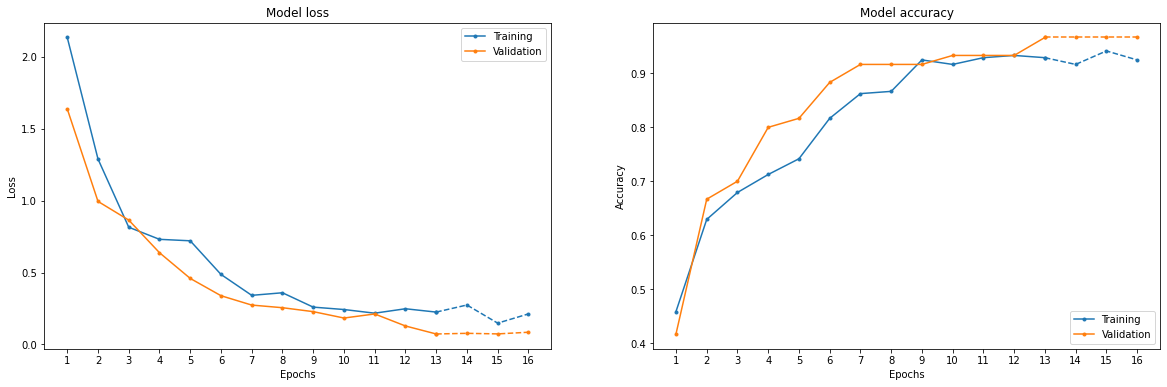

In [ ]:
resume_model_history(model_vgg_history, early_stop)

Come si può notare dal grafico, e dai valori riportati, il modello ottiene una buona accuracy e anche l'andamento sembra essere buono.

In [ ]:
# salvataggio del modello
model_vgg.save(drive_path + 'Model/Processing-2D/vgg16.h5')

Valutiamo quindi il modello sul test set precedentemente caricato.


Classification Report
               precision    recall  f1-score   support

     Ginevra       0.94      1.00      0.97        17
     Lorenzo       1.00      0.82      0.90        17
    Riccardo       0.89      1.00      0.94        17

    accuracy                           0.94        51
   macro avg       0.95      0.94      0.94        51
weighted avg       0.95      0.94      0.94        51



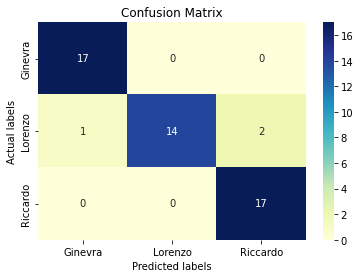

In [ ]:
# se necessario ricarico il modello da drive
#model_vgg = keras.models.load_model(drive_path + 'Model/Processing-2D/vgg16.h5')
# valuto il modello sul test set
pred,_ = evaluate_prediction(model_vgg, test_set, train_set.class_names)

Come previsto i risultati sono in linea con quelli del validation, è possibile notare come in generale il modello sia molto nel prevedere tutte e $3$ le classi. Tuttavia la classe riportante le immagini di 'Lorenzo' risulta essere lievemente peggiore con una recall di $0.82$. <br>
Proviamo inoltre a valutare il modello rispetto al tempo richiesto per predire una sola immagine, per farlo si effettua la predizione su un batch di immagini e si media il tempo totale. Ovviamente la tempistica è inficiata dalla potenza di calcolo e dal numero di GPU a disposizione (exe parallela).

In [ ]:
# PER AVERE UN TEMPO REALE E' MEGLIO FAR RIPARTIRE IL NOTEBOOK ED ESEGUIRE SOLTANTO QUESTA CELLA
# ALTRIMENTI ALCUNE PREDIZIONI POTREBBERO ESSERE IN MEMORIA

# calcolo il batch size del dataset (potevo fissarlo a mano, cosi è generico)
b_size = [len(l) for _, l in test_set.take(1)][0]
# ottengo il tempo necessario per la singola predizione
req_time = get_time_per_prediction(model_vgg, test_set, b_size)

# visualizzo il tempo medio per la predizione di ogni img
print("--- %s secondi necessari per predire una singola immagine! ---" % req_time)

--- 1.694 secondi necessari per predire una singola immagine! ---


Il tempo per la previsione risulta essere abbastanza elevato, complice anche la grandezza del modello. Questo può essere un fattore negativo in quanto non permette predizioni real-time. 

## MobileNetV2
Il secondo modello che consideriamo per il fine tuning è MobileNetV2. Questo modello ha un numero di parametri inferiore al precedente e richiede un numero minimo di operazioni, quindi anche il peso del modello è molto leggero: solo $14$MB. Nonostante questo sul task originale riesce a raggiungere gli stessi livelli di accuratezza di VGG16! Questo modello è stato infatti sviluppato da Google per essere utilizzato su dispositivi mobili. <br>
L'architettura di MobileNetV2 si basa su dei blocchi detti:

* ``inverted residual``. Che utilizza un blocco residuale invertito che attraverso una prima convoluzione per allargare l'immagine, una seconda convoluzione in profondità e infine una convoluzione $1x1$ per ridurre il numero di canali (al contrario la i blocchi residuali classici prima comprimono l'immagine e poi la riallargano). 
<figure>
<center>
<img src='https://user-images.githubusercontent.com/18547241/53912465-997fd900-401e-11e9-82b0-c0be0f2abf93.png' height = 100/></center>
</figure>


* ``linear bottleneck layer``. Permettono di non distruggere troppe informazioni con attivazioni non lineari.

L'architettura completa è quindi composta dai seguenti layers:
<figure>
<center>
<img src='https://miro.medium.com/max/1016/1*5iA55983nBMlQn9f6ICxKg.png' height = 300/>
<figcaption>MobileNetV2 architecture</figcaption></center>
</figure>

Dove $t$ è il fattore di espansione, $c$ il numero di canali in output, $n$ il numero di ripetizioni, $s$ lo stride. Per le convoluzioni spaziali è utilizzato un kernel $3x3$.


Si è scelto di provare a utilizzare questo modello in quanto, se efficace, potrebbe rendere possibile il riconoscimento in real-time sfruttando le immagini che arrivano in modo continuo da un video.

In [ ]:
# Carico il modello di base MobileNetV2
base_mn_model = MobileNetV2(weights='imagenet')

# taglio gli ultimi layer fully connected dal modello
base_mn_model = Model(inputs=base_mn_model.input, 
                 outputs=base_mn_model.get_layer(base_mn_model.layers[len(base_mn_model.layers)-2].name).output)
# visualizzo il nuovo summary
# base_mn_model.summary()

Una volta estratti i layer funzionali al nostro task definisco un nuovo modello che aggiunge dei nuovi layer utili per la classificazione. I layer estratti dal modello MobileNetV2 verranno ''bloccati'' durante il training della nuova rete in modo da non modificare i pesi precedentemente allenati. <br>

Come prima l'architettura finale è stata individuata dopo alcune prove.

In [ ]:
# voglio che tutti i layer già presenti non siano nuovamente trainati cosi mantengo i pesi
for layer in base_mn_model.layers:
  layer.trainable = False

# ---------- definisco la sequenza di operazioni del macro modello ----------
# input layer
inputs = keras.Input(shape=(224,224,3)) # layer di input
x = inputs

# ---------- DATA AUGMENTATION ----------
# Aggiungo dei layer per la data augmentation. Questi layer, per definizione,
# vengono eseguiti soltanto durante il training e non durante la fase di prediction
x = keras.layers.RandomFlip("horizontal")(x) # capovolge l'immagine orizzontalmente
# ruota l'immagine in un range di [-40,+40] gradi
x = keras.layers.RandomRotation(0.4, fill_mode = 'nearest')(x)
x = keras.layers.RandomZoom(0.5, 0.5)(x)
# cambia il contrasto dell'immagine in un range compreso tra [0.2, 1.8]
x = keras.layers.RandomContrast(0.8)(x)

# ---------- MOBILENET PREPROCESSING ----------
# applico lo stesso preprocessing applicato all'input di mobilenet
x = keras.applications.mobilenet_v2.preprocess_input(x)
# applico la rete mobilenet precedentemente estratta
x = base_mn_model(x)

# ---------- LAYER AGGIUNTIVI ----------
# Definisco alcuni layer aggiuntivi (SONO TRAINABILI!)
#x = keras.layers.Dense(8, activation = 'relu')(x)
#x = keras.layers.Dropout(0.1)(x)
# layer che mappa al numero di classi del nostro problema
x = keras.layers.Dense(3, activation = "softmax")(x)


# creo il macro modello
outputs = x
model_mn = keras.Model(inputs=inputs, outputs=outputs)

# compilo il modello e definisco la funzione di ottimizzazione
model_mn.compile(optimizer=keras.optimizers.RMSprop(learning_rate = 1e-03),#Adam(learning_rate = 1e-04),
                 loss='categorical_crossentropy',
                 metrics = "accuracy")

Si può verificare che il modello così creato contiene $2.261.827$ di cui $3.843$ trainabili. Il modello risulta quindi essere molto più piccolo del precedente e con molti pochi parametri da trainare.

In [ ]:
model_mn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 random_contrast (RandomCont  (None, 224, 224, 3)      0         
 rast)                                                           
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0   

Effettuiamo il training del modello con la stessa configurazione precedente, ovvero $100$ epoche massime ed EarlyStopping.

In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, min_delta = 0.001, 
                           verbose = 1, restore_best_weights = True) 

model_mn_history = model_mn.fit(train_set, epochs = 100,
                                validation_data = validation_set,
                                verbose = 1, callbacks = [early_stop])

Epoch 1/100
15/15 [==============================] - 11s 193ms/step - loss: 0.6677 - accuracy: 0.6750 - val_loss: 0.6254 - val_accuracy: 0.8167
Epoch 2/100
15/15 [==============================] - 1s 82ms/step - loss: 0.3753 - accuracy: 0.8792 - val_loss: 0.6019 - val_accuracy: 0.7500
Epoch 3/100
15/15 [==============================] - 1s 81ms/step - loss: 0.2741 - accuracy: 0.9125 - val_loss: 0.3826 - val_accuracy: 0.8833
Epoch 4/100
15/15 [==============================] - 1s 80ms/step - loss: 0.2513 - accuracy: 0.9292 - val_loss: 0.2938 - val_accuracy: 0.9500
Epoch 5/100
15/15 [==============================] - 1s 81ms/step - loss: 0.1747 - accuracy: 0.9500 - val_loss: 0.2744 - val_accuracy: 0.9500
Epoch 6/100
15/15 [==============================] - 1s 80ms/step - loss: 0.1418 - accuracy: 0.9458 - val_loss: 0.2243 - val_accuracy: 0.9500
Epoch 7/100
15/15 [==============================] - 1s 82ms/step - loss: 0.0896 - accuracy: 0.9875 - val_loss: 0.1962 - val_accuracy: 0.9500
Epoc

Si visualizza quindi il grafico di training, le epoche rimosse per via dell'early stopping sono mostrate con linee tratteggiate.

Numero di epoche totali: 28
Epoca migliore (weights restored): 25
Accuracy training set all'epoca 25: 0.9958333373069763
Accuracy validation set all'epoca 25: 0.9833333492279053
Loss training set all'epoca 25: 0.027400493621826172
Loss validation set all'epoca 25: 0.05824185907840729





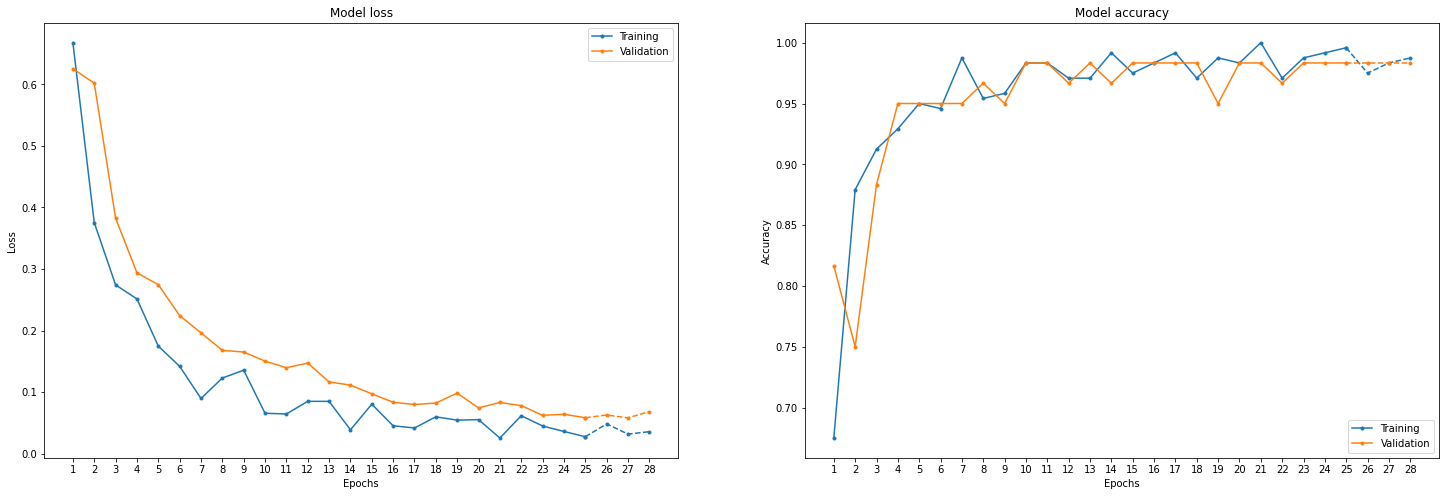

In [ ]:
resume_model_history(model_mn_history, early_stop, (25, 8))

# Numero di epoche totali: 46
# Accuracy training set all'epoca 43: 0.966
# Accuracy validation set all'epoca 43: 0.983
# Loss training set all'epoca 43: 0.133
# Loss validation set all'epoca 43: 0.082

Come si può notare dal grafico, e dai valori riportati, il modello ottiene una buona accuracy. Dal punto di vista dell'andamento invece sembra leggermente essere in overfitting se ci concentriamo sulla metrica di loss.

In [ ]:
# salvo il modello (Nota: come riportato nel warning il modello così salvato può 
# essere usato solo per fare predizioni e non per far ripartire il training)
model_mn.save(drive_path + 'Model/Processing-2D/mobilenet.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Valutiamo quindi il modello sul medesimo test set già utilizzato


Classification Report
               precision    recall  f1-score   support

     Ginevra       1.00      1.00      1.00        17
     Lorenzo       1.00      0.94      0.97        17
    Riccardo       0.94      1.00      0.97        17

    accuracy                           0.98        51
   macro avg       0.98      0.98      0.98        51
weighted avg       0.98      0.98      0.98        51



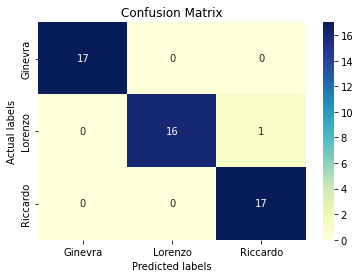

In [ ]:
# Se necessario carico il modello da drive
model_mn = keras.models.load_model(drive_path + 'Model/Processing-2D/mobilenet.h5')
# calcolo le predizioni
_,_ = evaluate_prediction(model_mn, test_set, train_set.class_names)

Si può notare che, come atteso, a livello di performance il modello è leggermente meglio del modello VGG precedentemente creato. <br>
Valutiamo quindi il modello rispetto al tempo necessario per la predizione:

In [ ]:
# PER AVERE UN TEMPO REALE E' MEGLIO FAR RIPARTIRE IL NOTEBOOK ED ESEGUIRE SOLTANTO QUESTA CELLA
# ALTRIMENTI ALCUNE PREDIZIONI POTREBBERO ESSERE IN MEMORIA

# calcolo il batch size del dataset (potevo fissarlo a mano, cosi è generico)
b_size = [len(l) for _, l in test_set.take(1)][0]
# ottengo il tempo necessario per la singola predizione
req_time = get_time_per_prediction(model_mn, test_set, b_size)

# visualizzo il tempo medio per la predizione di ogni img
print("--- %s secondi necessari per predire una singola immagine! ---" % req_time)

--- 0.125 secondi necessari per predire una singola immagine! ---


Possiamo notare come il tempo di predizione sia notevolmente minore rispetto a VGG, con un decremento di più di un secondo per immagine. Questo rende il modello molto più generico ed applicabile anche ad applicazioni real time, o quasi. 

## VGGFace
Come ultima architettura si è deciso di utilizzare un modello preadddestrato su un task di riconoscimento del volto. In questo caso ci si aspetta che le performance siano significativamente migliori rispetto ai due modelli precedenti data la similarità col task originale e dunque con i pesi "bloccati".
In particolare si è deciso di utilizzare come architettura VGGFace i cui pesi sono stati scaricati da questo [link](https://drive.google.com/file/d/1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo/view). <br>

Per lo sviluppo dell'architettura si sono utilizzate le seguenti reference:


* [Reference1](https://github.com/rcmalli/keras-vggface)
*   [Reference2](https://medium.com/analytics-vidhya/face-recognition-with-vgg-face-in-keras-96e6bc1951d5)
*   [Reference3](https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/)


In [ ]:
def base_vgg_face(path_to_weights):
  """
   definisce l'architettura standard del modello VGGFace e che carica i pesi pretrainati

   :param str path_to_weights: Percorso in cui si trova il file .h5 con i pesi

   :return: Il modello con i pesi caricati
   :rtype: keras.engine.functional.Functional
  """

  model = Sequential()
  model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
  model.add(Convolution2D(64, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  model.add(ZeroPadding2D((1,1)))	
  model.add(Convolution2D(128, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(256, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(256, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(256, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  model.add(Convolution2D(4096, (7, 7), activation='relu'))
  model.add(keras.layers.Dropout(0.5))
  model.add(Convolution2D(4096, (1, 1), activation='relu'))
  model.add(keras.layers.Dropout(0.5))
  model.add(Convolution2D(2622, (1, 1)))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Activation('softmax'))

  # Load VGG Face model weights
  model.load_weights(path_to_weights)

  return model

Definiamo quindi l'architettura standard della rete scelta e carichiamo i pesi pretrainati. Dal summary si nota come questo modello abbia tantissimi parametri, non ci attendiamo quindi predizioni particolarmente veloci ma piuttosto livelli di accuratezza molto elevati.

In [ ]:
# ottengo il modello base di vggFace
vgg_face = base_vgg_face(drive_path + 'Notebook/Processing-2D/vgg_face_weights.h5')
# elimino l'ultimo layer di softmax. Cosi l'ultimo layer è il flatten con output a 2622
vgg_face = Model(inputs=vgg_face.layers[0].input,outputs=vgg_face.layers[-2].output) 

vgg_face.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_input (Input  [(None, 224, 224, 3)]    0         
 Layer)                                                          
                                                                 
 zero_padding2d (ZeroPadding  (None, 226, 226, 3)      0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 226, 226, 64)     0         
 ng2D)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                             

Come per i modelli precedenti si blocca l'apprendimento dei pesi dell'architettura base, cosi da non aggiornarli nell'apprendimento. Vengono  inoltre aggiunti nuovi layer, trainabili, che verranno addestrati per il task d'interesse. <br>
Dopo alcune prove, e considerando anche il fatto che le features estratte dai primi layer sono già specifiche per la face recognition, si è deciso di non introdurre layer di data augmentation.

In [ ]:
# voglio che tutti i layer già presenti non siano nuovamente trainati cosi mantengo i pesi
for layer in vgg_face.layers:
  layer.trainable = False

# ---------- definisco la sequenza di operazioni del macro modello ----------
# input layer
inputs = keras.Input(shape=model_input_shape) # layer di input
x = inputs

# ---------- VGGFace ----------
# applico la rete VggFace precedentemente estratta
x = vgg_face(x)

# ---------- LAYER AGGIUNTIVI ----------
# Definisco alcuni layer aggiuntivi (SONO TRAINABILI!)
x = keras.layers.Dense(64, activation = 'relu')(x)
x = keras.layers.Dense(32, activation = 'relu')(x)
# layer che mappa al numero di classi del nostro problema
x = keras.layers.Dense(3, activation = "softmax")(x)


# creo il macro modello
outputs = x
model_vgg_face = keras.Model(inputs=inputs, outputs=outputs)

# compilo il modello e definisco la funzione di ottimizzazione
model_vgg_face.compile(optimizer=Adam(learning_rate = 1e-04),
                       loss='categorical_crossentropy',
                       metrics = "accuracy")

In totale questo modello è composto da $145.172.929$ parametri di cui solo $170.051$ addestrabili. Rispetto ai precedenti risulta essere un modello molto "grosso" che richiederà anche tanto spazio in memoria.

In [ ]:
# visualizzo la summary del modello
model_vgg_face.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 model (Functional)          (None, 2622)              145002878 
                                                                 
 dense (Dense)               (None, 64)                167872    
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 145,172,929
Trainable params: 170,051
Non-trainable params: 145,002,878
_________________________________________________________________


In [ ]:
# early stopping per fermare il modello in caso in cui la loss del validation non migliori per
# 3 iterazioni consecutive. Viene anche ripristinata la migliore epoca fino a quel punto
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2, min_delta = 0.0001, 
                           verbose = 1, restore_best_weights = True) 

# addestro il modello
model_face_history = model_vgg_face.fit(train_set, epochs = 100,
                                        validation_data = validation_set,
                                        verbose = 1, callbacks = [early_stop])

Epoch 1/100
15/15 [==============================] - 5s 276ms/step - loss: 1.5045 - accuracy: 0.6667 - val_loss: 0.3531 - val_accuracy: 0.8833
Epoch 2/100
15/15 [==============================] - 3s 192ms/step - loss: 0.1947 - accuracy: 0.9292 - val_loss: 0.0250 - val_accuracy: 1.0000
Epoch 3/100
15/15 [==============================] - 4s 244ms/step - loss: 0.0352 - accuracy: 0.9875 - val_loss: 0.0140 - val_accuracy: 1.0000
Epoch 4/100
15/15 [==============================] - 3s 209ms/step - loss: 0.0310 - accuracy: 0.9917 - val_loss: 0.0064 - val_accuracy: 1.0000
Epoch 5/100
15/15 [==============================] - 3s 190ms/step - loss: 0.0600 - accuracy: 0.9792 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 6/100
15/15 [==============================] - 3s 164ms/step - loss: 0.0258 - accuracy: 0.9917 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 7/100
15/15 [==============================] - 3s 190ms/step - loss: 0.0139 - accuracy: 0.9958 - val_loss: 0.0031 - val_accuracy: 1.0000

Visualizzo l'andamento grafico del training

Numero di epoche totali: 16
Epoca migliore (weights restored): 14
Accuracy training set all'epoca 14: 1.0
Accuracy validation set all'epoca 14: 1.0
Loss training set all'epoca 14: 0.004908929578959942
Loss validation set all'epoca 14: 0.0009881380246952176





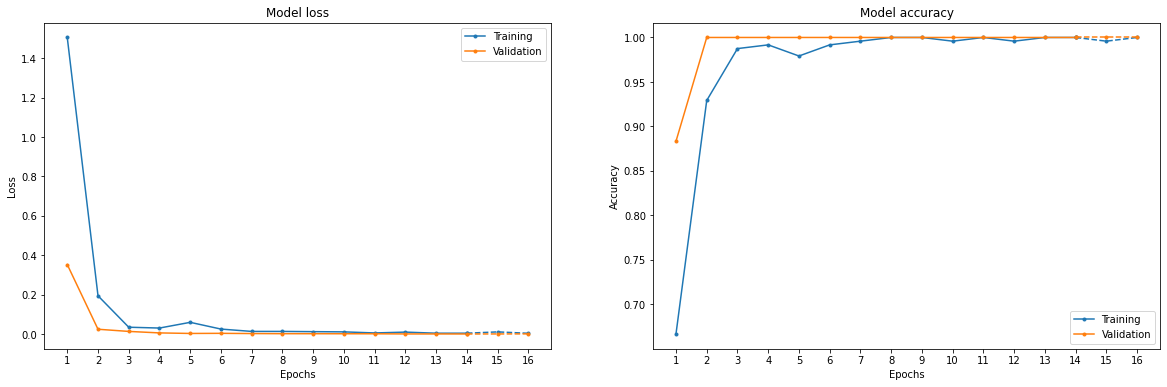

In [ ]:
resume_model_history(model_face_history, early_stop)

Dall'andamento del grafico possiamo notare come l'apprendimento sia molto più veloce, già dalla seconda epoca viene infatti raggiunta l'accuracy massima. 

In [ ]:
# salvataggio del modello
model_vgg_face.save(drive_path + 'Model/Processing-2D/vggface.h5')


Classification Report
               precision    recall  f1-score   support

     Ginevra       1.00      1.00      1.00        17
     Lorenzo       1.00      1.00      1.00        17
    Riccardo       1.00      1.00      1.00        17

    accuracy                           1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51



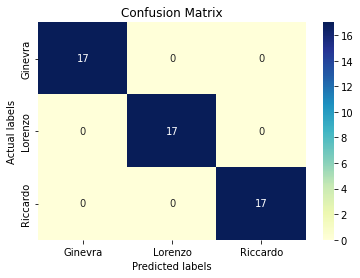

In [ ]:
# se necessario ricarico il modello da drive
#model_vgg_face = keras.models.load_model(drive_path + 'Model/Processing-2D/vggface.h5')
# effettuo le predizioni sul test set
_,_ = evaluate_prediction(model_vgg_face, test_set, train_set.class_names)

I risultati sul test set confermano quanto visto sul validation set, con tutte le immagini correttamente classificate.<br>

Valutiamo quindi il modello rispetto al tempo, come anticipato ci attendiamo un tempo medio molto alto per la singola immagine.

In [ ]:
# PER AVERE UN TEMPO REALE E' MEGLIO FAR RIPARTIRE IL NOTEBOOK ED ESEGUIRE SOLTANTO QUESTA CELLA
# ALTRIMENTI ALCUNE PREDIZIONI POTREBBERO ESSERE IN MEMORIA

# calcolo il batch size del dataset (potevo fissarlo a mano, cosi è generico)
b_size = [len(l) for _, l in test_set.take(1)][0]
# ottengo il tempo necessario per la singola predizione
req_time = get_time_per_prediction(model_vgg, test_set, b_size)

# visualizzo il tempo medio per la predizione di ogni img
print("--- %s secondi necessari per predire una singola immagine! ---" % req_time)

--- 1.868 secondi necessari per predire una singola immagine! ---


Il tempo richiesto, come atteso, è sicuramente molto alto e maggiore dei due modelli precedenti. Questo non permette sicuramente di applicare il modello in real-time, tuttavia le performace ottime raggiunte potrebbero renderlo ideale per altri task specifici.

## Test con immagini reali
Proviamo ad eseguire alcune predizioni su immagini reali scattate in diverse occasioni per verificare le performance dei modelli. Le immagini sono state ritagliate per diminuire il peso, alleggerendo cosi il tempo richiesto per il face detector ed i modelli ma anche per tagliare eventuali persone estranee presenti.

In [ ]:
# definisco il face detector
face_detector = dlib.cnn_face_detection_model_v1("/content/mmod_human_face_detector.dat")
# definisco il dizionario che associa nomi e numeri della predizioni
dict_name = {0: 'Ginevra', 1: 'Lorenzo', 2: 'Riccardo'}

In [ ]:
def wild_test(fold_path, face_detector, model, dict_names):
  """
  Funzione che itera sulle immagini presenti nella cartella e applica in sequenza
  face detector e il modello predittivo, quest'ultimo solo nei casi in cui si rilevi 
  almeno un volto.
  
  :param str fold_path: percorso in cui si trovano le immagini
  :param dlib.cnn_face_detection_model_v1 face_detector: face detector per individuare i volti
  :param keras.engine.functional.Functional model: Modello keras trainato con cui effettuare le predizioni
  :param str{} dict_names: dizionario che associa la previsione numerica ai relativi nomi

  """
  # count per sapere in quale subplot plottare l'immagine successiva
  count = 0
  # definisco il plot
  plt.figure(figsize=(25, 20))
  plt.tight_layout()

  # scorro su tutte le immagini presenti nella cartella, applico il face 
  # detector e il modello. Visualizzo a video l'immagine con la predizione come titolo
  for img_path in os.listdir(fold_path):
    img = cv.imread(os.path.join(fold_path, img_path))

    # dlib si aspetta un imamgine a colori RGB, quindi converto i colori
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    # applico il face detector dlib. In questo caso le immagini pesano molto
    # ed i soggetti siamo sicuri essere in primo piano, evitiamo quindi di zoommare più volte 
    # l'immagine per individuare i volti (cosi evitiamo OOM)
    faces = face_detector(img_rgb)

    # per ogni volto trovato croppo l'immagine e la salvo nella nuova directory
    # l'ipotesi ideale è che ci sia un solo volto ma ci sono casi in cui ce ne sono 0
    # o più di 1
    for i, d in enumerate(faces):
      left=d.rect.left() #x1
      top=d.rect.top() #y1
      right=d.rect.right() #x2
      bottom=d.rect.bottom() #y2

      # gestisco possibili errori nei valori
      left = max(0, left)
      top = max(0, top)

      # calcolo larghezza e altezza dell'immagine
      width=right-left
      height=bottom-top

      # confidence della detection
      confidence = d.confidence
      
      # print di alert se vengono individuati piu di due volti
      if (i >= 1):
        print("Individuato secondo volto nell'immagine: ", img_path, 'con confidence: ', confidence)
      
      # estraggo il crop
      crop = img_rgb[top:top+height, left:left+width]
      
      # ridimensiono il crop a 224x224
      crop = cv.resize(crop, (224, 224)) 
      # aggiungo una dim all'immagine
      img_mod = np.expand_dims(crop, axis = 0)
      
      # applico il modello
      y_pred = np.argmax(model.predict(img_mod))
      
      # aggiungo un nuovo subplot
      ax = plt.subplot(6, 5, count + 1)
      # visualizzo l'immagine
      plt.imshow(crop.astype("uint8"))
      plt.title(dict_names[y_pred])
      # passo al plot successivo
      count = count +1 

### MobileNet-V2
Provo ad effettuare le predizioni usando il modello mobilenet-V$2$.

<---------- PREDIZIONI CON MOBILENET-V2 ---------->
Individuato secondo volto nell'immagine:  ginevra_lorenzo.jpg con confidence:  1.0190534591674805
Individuato secondo volto nell'immagine:  ginevra_lorenzo2.jpg con confidence:  1.0341452360153198
Tempo totale richiesto:  3.441


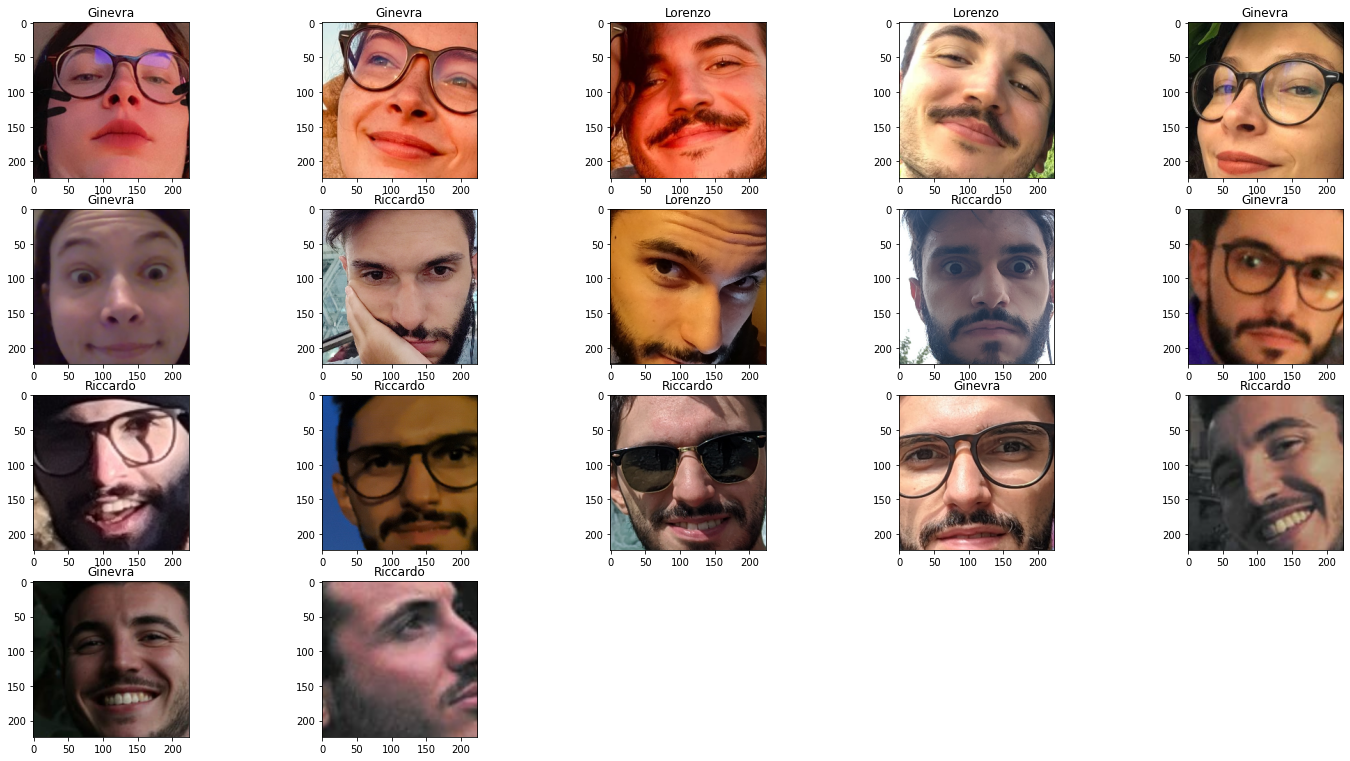

In [ ]:
print('<---------- PREDIZIONI CON MOBILENET-V2 ---------->')
# carico il modello
model_mn = keras.models.load_model(drive_path + 'Model/Processing-2D/mobilenet.h5')

# tempo di inizio predizione
start_time = time.time()
# chiamo la funzione per effettuare le previsioni
wild_test(drive_path + 'Data/immagini/Test_Wild', face_detector, model_mn, dict_name)

print('Tempo totale richiesto: ', round((time.time() - start_time), 3))

Possiamo notare che correttamente il face detector individua i volti multipli, ove presenti, nelle immagini. Inoltre questo modello sembra funzionare abbastanza bene anche se in alcuni casi abbiamo dei riconoscimenti errati. <br>
Nello specifico possiamo evidenziare che in alcune foto di 'Riccardo' con gli occhiali egli venga scambiato con 'Ginevra', questo può essere atteso in quanto nel training vi erano poche immagini di 'Riccardo' con gli occhiali, mentre tutte le foto di 'Ginevra' erano con gli occhiali. <br>
Inoltre nelle foto con volti ruotati o con luci "strane" si hanno i riconoscimenti più errati.

### VGG16
Utilizzo le stesse immagini di prima ma questa volta con il modello VGG$16$.

<----------------- PREDIZIONI CON VGG-16 ----------------->
Individuato secondo volto nell'immagine:  ginevra_lorenzo.jpg con confidence:  1.0190534591674805
Individuato secondo volto nell'immagine:  ginevra_lorenzo2.jpg con confidence:  1.0341452360153198
Tempo totale richiesto con VGG-16:  2.956


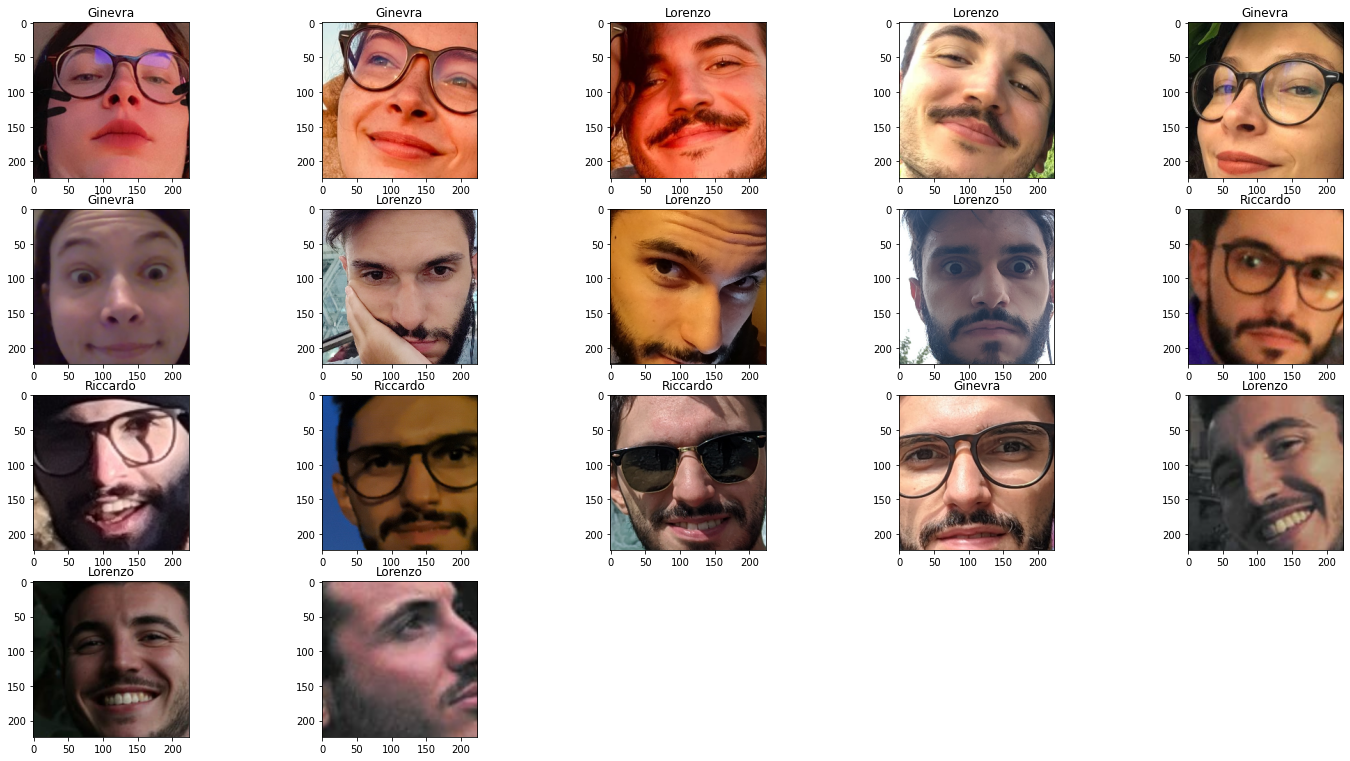

In [ ]:
print('<----------------- PREDIZIONI CON VGG-16 ----------------->')
# carico il modello
model = keras.models.load_model(drive_path + 'Model/Processing-2D/vgg16.h5')

# tempo di inizio predizione
start_time = time.time()
# chiamo la funzione per effettuare le previsioni
wild_test(drive_path + 'Data/immagini/Test_Wild', face_detector, model, dict_name)

print('Tempo totale richiesto con VGG-16: ', round((time.time() - start_time), 3))

Possiamo notare come VGG risolva molti dei casi errati precedentemente individuati, in questo caso vi sono infatti molti meno riconoscimenti errati. Soprattutto vengono confusi 'Riccardo' e 'Lorenzo'.

### VGGFace
In questo ultimo test applichiamo il modello VGGFace, dal quale ci attendiamo i risultati migliori.

<----------------- PREDIZIONI CON VGGFace ----------------->
Individuato secondo volto nell'immagine:  ginevra_lorenzo.jpg con confidence:  1.0190534591674805
Individuato secondo volto nell'immagine:  ginevra_lorenzo2.jpg con confidence:  1.0341452360153198
Tempo totale richiesto con VGGFace:  3.778


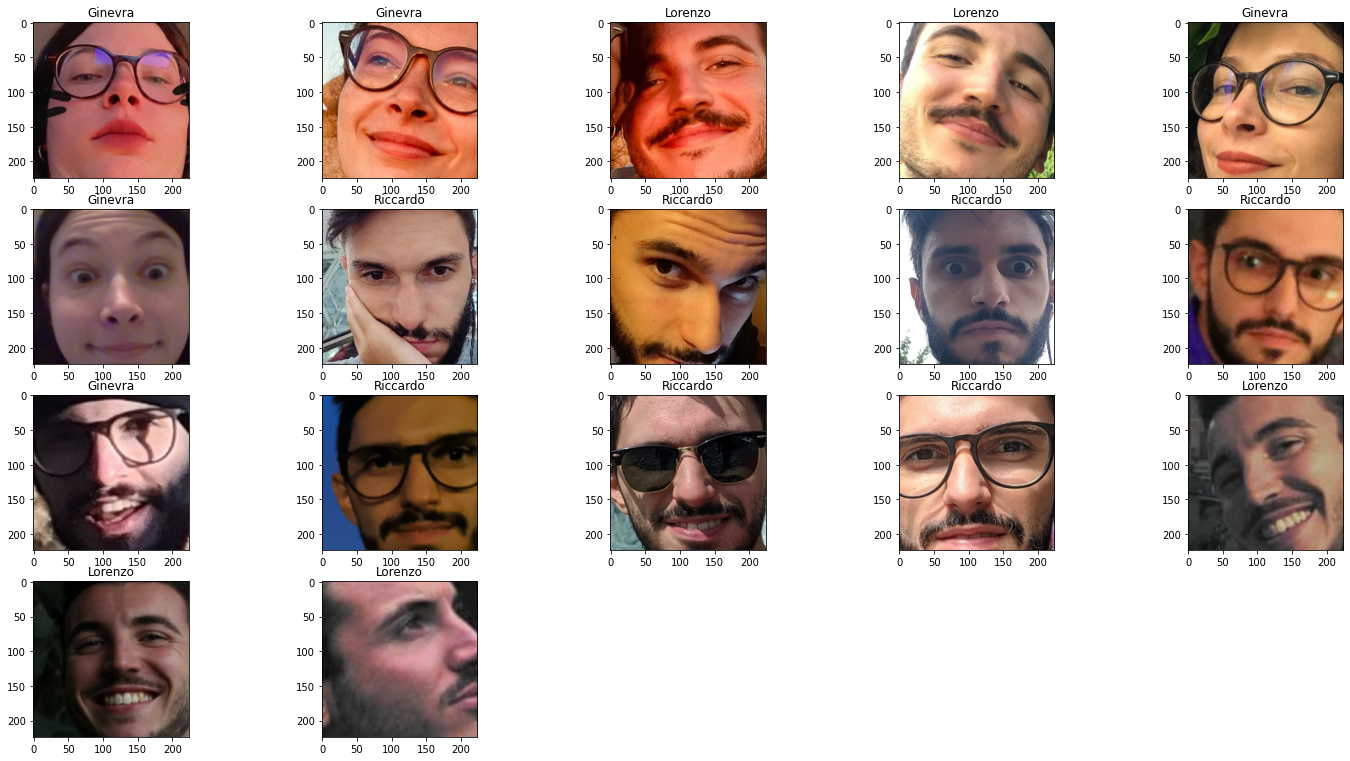

In [ ]:
print('<----------------- PREDIZIONI CON VGGFace ----------------->')
# carico il modello
model = keras.models.load_model(drive_path + 'Model/Processing-2D/vggface.h5')

# tempo di inizio predizione
start_time = time.time()
# chiamo la funzione per effettuare le previsioni
wild_test(drive_path + 'Data/immagini/Test_Wild', face_detector, model, dict_name)

print('Tempo totale richiesto con VGGFace: ', round((time.time() - start_time), 3))

Come atteso questo modello riesce a riconoscere tutti i volti, eccezion fatta per una singola foto in cui 'Riccardo' viene segnalato come 'Ginevra'. Tuttavia richiede un tempo superiore rispetto agli altri modelli.

## Considerazioni Finali
In conclusione è possibile osservare che i modelli di fine tuning che utilizzano i pesi di imagenet risultano essere abbastanza validi, anche se con un ambiente (luci, sfondo, colori, ...) diverso mostrano i propri limiti. Questo perchè comunque nel dataset originale imagenet non sono presenti volti. Mentre, com'è lecito attendersi, il fine tuning della rete VGGFace, che contiene pesi pretrainati su un task di riconoscimento del volto, ottiene performance migliori e più robuste rispetto ai cambiamenti. <br>

Le reti proposte si differenziano anche per il tempo richiesto per la singola predizione, rendendo la rete più o meno adatta ad applicazioni mobile e/o real-time. Ad esempio la rete VGGFace pesa nel complesso oltre $500$MB e dunque viene difficile pensare di poterla inserire in un applicazione mobile, mentre per altri task in cui è possibile avvalersi di hardware più potenti risulta essere la soluzione ideale in quanto fornisce previsioni il più possibile accurate. 

In [2]:
# download notebook in .html extension
%%shell
jupyter nbconvert --to html '/content/drive/MyDrive/Confalonieri_Mariani_Mora_DSIM/Notebook/Processing-2D/2_FaceRecognition.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Confalonieri_Mariani_Mora_DSIM/Notebook/Processing-2D/2_FaceRecognition.ipynb to html
[NbConvertApp] Writing 4271643 bytes to /content/drive/MyDrive/Confalonieri_Mariani_Mora_DSIM/Notebook/Processing-2D/2_FaceRecognition.html
